## Keras denoising autoencoder

Modified version from keras example: https://github.com/keras-team/keras/blob/master/examples/mnist_denoising_autoencoder.py

In [1]:
'''Trains a denoising autoencoder on MNIST dataset.
Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true signal.
Noise + Data ---> Denoising Autoencoder ---> Data
Given a training dataset of corrupted data as input and
true signal as output, a denoising autoencoder can recover the
hidden structure to generate clean data.
This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
import datetime
import models
import platform

from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util
from yass.augment import make, util
from yass.augment.noise import noise_cov
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import preprocess

import numpy as np
from scipy.io import loadmat

from dstools import plot

LOCAL = platform.system() == 'Darwin'

# logging.basicConfig(level=logging.DEBUG)

In [3]:
if LOCAL:
    yass.set_config("../config/49-local.yaml")
else:
    yass.set_config("../config/49-lab.yaml")

CONFIG = read_config()

In [4]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'nnet')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

if LOCAL:
    path_to_here = path.expanduser('~/dev/lab/private-yass/nnet')
else:
    path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [5]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

# remove spikes at the beginning (2) and end (1) to avoid errors
# when getting waveforms
gt = gt[2:-1]

# shift ids to start at 0
gt[:, 1] = gt[:, 1] - 1

# compensate alignment
gt[:, 0] = gt[:, 0] + 10

In [6]:
def filename(extension=None):
    """Generate a valid directory name with the current datetime
    """
    now = datetime.datetime.now()
    name =  now.strftime('%d-%b-%Y@%H-%M-%S')
    
    if extension is not None:
        name += '.'+extension
    
    return name

In [7]:
# use all templates
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

# chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11,
#                     12, 13, 14, 15, 16, 17, 18, 19,
#                     22, 23, 24, 25, 26, 27, 28, 29,
#                     30, 31, 32, 33, 34, 35, 36, 37,
#                     38, 39, 41, 42, 43, 44, 45, 46,
#                     47, 48]

In [8]:
templates, _ = preprocess(CONFIG, gt,
                          path_to_standarized,
                          chosen_templates)

100%|██████████| 3/3 [00:08<00:00,  2.87s/it]


In [9]:
templates.shape

(41, 61, 7)

In [10]:
min_amplitude = 5
max_amplitude = 80
nk = 1000
noise_ratio = 1

x_clean = util.make_clean(templates, min_amplitude, max_amplitude, nk)

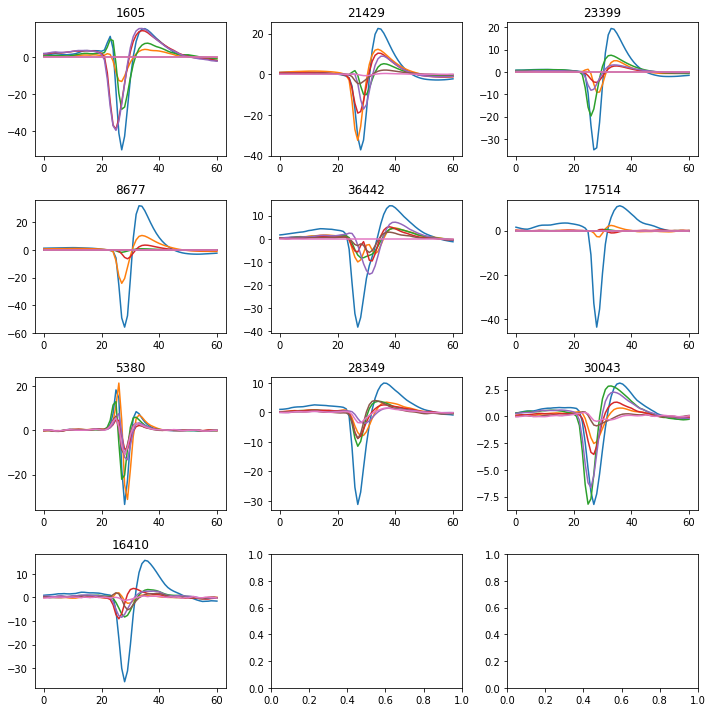

In [11]:
plot.grid_from_array(x_clean, axis=0, elements=10, figsize=(10, 10))

In [12]:
# determine noise covariance structure
spatial_SIG, temporal_SIG = noise_cov(path_to_standarized,
                                      CONFIG.neigh_channels,
                                      CONFIG.geom,
                                      templates.shape[1])

# make noise
noise = util.make_noise(x_clean, noise_ratio, templates, spatial_SIG,
                        temporal_SIG)

In [13]:
noise.shape

(41000, 61, 7)

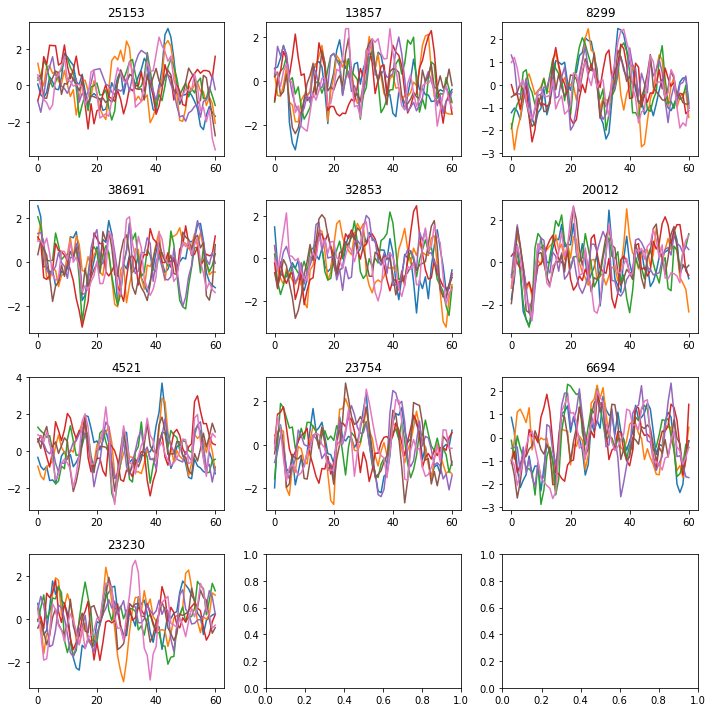

In [14]:
plot.grid_from_array(noise, axis=0, elements=10, figsize=(10, 10))

In [15]:
n = x_clean.shape[0]
prop = 0.7

train_idx = np.random.choice(n, size=int(n * prop), replace=False)

test_idx = np.ones(n, dtype=bool)
test_idx[~train_idx] = False

In [16]:
# split in train test
np.random.shuffle(x_clean)

x_train = x_clean[train_idx]
x_test = x_clean[test_idx]

In [17]:
x_train_noisy = x_train + noise[train_idx]
x_test_noisy = x_test + noise[test_idx]

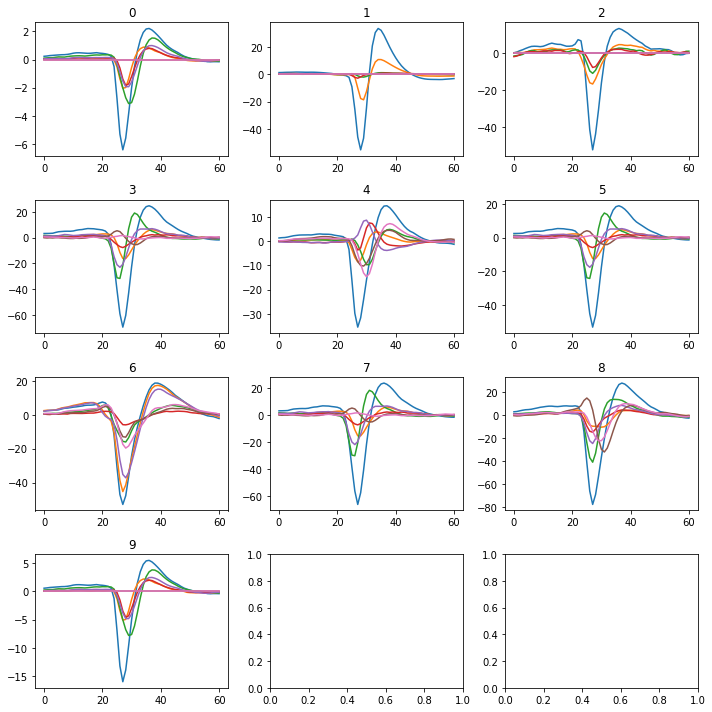

In [18]:
plot.grid_from_array(x_train, axis=0, elements=range(10),
                     figsize=(10, 10))

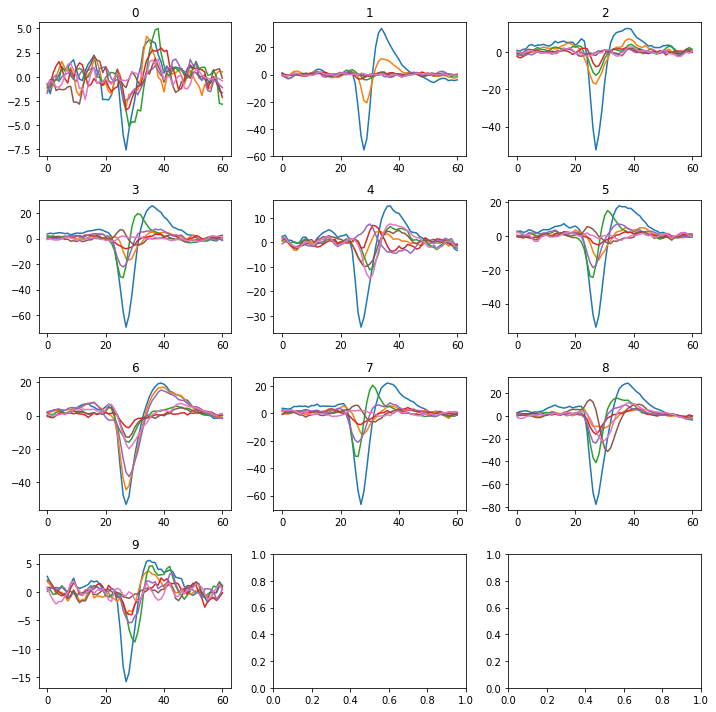

In [19]:
plot.grid_from_array(x_train_noisy, axis=0, elements=range(10),
                     figsize=(10, 10))

In [20]:
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

x_train_noisy = x_train_noisy[:, :, :, np.newaxis]
x_test_noisy = x_test_noisy[:, :, :, np.newaxis]

In [21]:
print(x_train_noisy.shape, x_train.shape,
      x_test_noisy.shape, x_test.shape)

(28699, 61, 7, 1) (28699, 61, 7, 1) (12301, 61, 7, 1) (12301, 61, 7, 1)


In [22]:
# Network parameters
input_shape = (61, 7, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=1,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)


outputs = Activation('linear', name='decoder_output')(x)

# outputs = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 61, 7, 1)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 7, 32)         320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 7, 64)         18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 27328)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                437264    
Total params: 456,080
Trainable params: 456,080
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
deco

In [ ]:
# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

Train on 28699 samples, validate on 12301 samples
Epoch 1/30
28699/28699 [==============================] - 10s 365us/step - loss: 4.0220 - val_loss: 0.2251
Epoch 2/30
28699/28699 [==============================] - 8s 292us/step - loss: 0.1142 - val_loss: 0.0860
Epoch 3/30
28699/28699 [==============================] - 8s 290us/step - loss: 0.0800 - val_loss: 0.0678
Epoch 4/30
28699/28699 [==============================] - 8s 291us/step - loss: 0.0704 - val_loss: 0.0633
Epoch 5/30
28699/28699 [==============================] - 8s 291us/step - loss: 0.0580 - val_loss: 0.0541
Epoch 6/30
28699/28699 [==============================] - 8s 291us/step - loss: 0.0727 - val_loss: 0.0623
Epoch 7/30
28699/28699 [==============================] - 8s 291us/step - loss: 0.0718 - val_loss: 0.2248
Epoch 8/30
28699/28699 [==============================] - 8s 291us/step - loss: 0.0488 - val_loss: 0.0387
Epoch 9/30
28699/28699 [==============================] - 8s 290us/step - loss: 0.0394 - val_loss: 0.

In [ ]:
x_test_noisy_ = np.squeeze(x_test_noisy)
x_test_ = np.squeeze(x_test)
x_decoded_ = np.squeeze(x_decoded)

In [ ]:
plot.grid_from_array(x_test_noisy_, axis=0, elements=[1, 2],
                     figsize=(10, 6))

In [ ]:
plot.grid_from_array(x_test_, axis=0, elements=[1,2],
                     figsize=(10, 6))

In [ ]:
plot.grid_from_array(x_decoded_, axis=0, elements=[1,2],
                     figsize=(10, 6))